## Machine Learning: Introductory Neural Networks Project.

Neural Networks are Machine Learning models, that are able to make decisions in a manner similar to the human brain, by using processes that mimic the way biological neurons work together to identify phenomena, weigh options and arrive at conclusions.

Every neural network architecture consists of layers of nodes (artificial neurons)-an input layer, one or multiple hidden layers and an output layer. Each node connects to others of the next layer, and has its own associated weight and threshold. If the output of any individual node is above the specified threshold value, that node is activated, sending data to the next layer of the network. Otherwise, no data is passed along to the next layer of the network.

Every neural network must train on particular sets of data called training data, in order to be able to make accurate decisions. Once successfully trained, they can predict data or cluster and categorize them efficiently.The training of the model on a particular dataset goes like this: 
Once an input layer is determined, weights are assigned. These weights help determine the importance of any given variable, with larger ones contributing more significantly to the output compared to other inputs. All inputs are then multiplied by their respective weights and then summed. Afterward, the output is passed through an activation function, which determines the output. If that output exceeds a given threshold, it “fires” (or activates) the node, passing data to the next layer in the network. This results in the output of one node becoming in the input of the next node. This process of passing data from one layer to the next layer defines this neural network as a feedforward network.

The goal of this particular project is to develop a neural network that predicts the date in which an ancient greek inscription is written, while simultaneously tasting the effects of changing different hyperparameters of the model or applying different techniques to boost the model's performance.  

In [13]:
# Imports
import pandas as pd
import numpy as np
import nltk
import utils as ul
import matplotlib.pyplot as plt
import importlib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

importlib.reload(ul)

<module 'utils' from 'c:\\Users\\kwnka\\vs-code projects\\CompIntel\\project_A\\utils.py'>

### Preprocessing 

1. **Loading**: To start off the dataset is loaded into a Pandas dataframe and some information is printed using the `print_info_df()` function, to help understand the data better. Afterwards we create a new dataframe column, naming it *mean dates*, which is the mean of the two dates given for each particular inscription
2. **BoW with Tf-Idf**: In order to implement the Bag of Words model using tf-idf vectorization, the following steps are performed:
    * An object of the `TfidfVectorizer()` Class is instantiated.
    * The method `fit_transform()` of the Class is called for this object in order for the vocabulary to be constructed and for the inscriptions to be transformed into the appropriate form.
    * We determine the number of features, meaning the length of the vector each inscription will be transformed into. 
    * The **output** of the vectorizer is a **sparse matrix**, where the rows are the different inscriptions and columns the different features of the vocabulary. A value in a particular position of the matrix signifies the existance of the particular feature in that inscription.
3. **Splitting Dataset Into Folds**: Using the custom-made `split_to_folds()` function, the input and target datasets are split into 5 Folds, in order for all the experiments to run using 5-Fold Cross Validation.

After fininshing the preprocessing, we end up having a [2802, 3000] matrix, which is the 2802 different inscriptions we have, transformed into 3000-valued vectors.

In [14]:
df = pd.read_csv('iphi2802.csv', delimiter='\t')

ul.print_info_df(df)

# Create a new column 'mean_date' in the dataframe.  
df['mean_date'] = df[['date_min', 'date_max']].mean(axis=1)

stopwords = nltk.corpus.stopwords.words('greek') 
texts = ul.vectorize_inscriptions(df, stopwords, 3000)
dates = df['mean_date'].values.reshape(-1,1)

# Scale both input and output data
scaler = MinMaxScaler()
X = scaler.fit_transform(texts)
y = scaler.fit_transform(dates)

# Initialize 5-Fold Cross Validation.
fold_dataset = ul.split_to_folds(5, X, y)


Original shape of Dataset: (2802, 11)


Number of NULL values per column:id                0
text              0
metadata          0
region_main_id    0
region_main       0
region_sub_id     0
region_sub        0
date_str          0
date_min          0
date_max          0
date_circa        0
dtype: int64


Number of unique values per column:id                2802
text              2795
metadata          2530
region_main_id      14
region_main         14
region_sub_id       73
region_sub          71
date_str          1384
date_min           505
date_max           509
date_circa           2
dtype: int64



c:\Users\kwnka\miniconda3\envs\computIntel\lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['δι', 'ἀλλ'] not in stop_words.
  warnings.warn(


The shape of the matrix is: (2802, 3000) 



In [9]:
# Train and evaluate various models 
mean_losses_tr = []
mean_losses_ts = []
layer_configs = [
    [3],
    [2],
    [3, 2],
    [3, 2, 2],
    [4, 2, 2]
]

for layer in layer_configs:
    mean_train_loss, mean_test_loss = ul.train_model(3000, layer, 0.001, 0.9, fold_dataset, 32, 50, False, False, 0.0, 0.0)
    mean_losses_tr.append(mean_train_loss)
    mean_losses_ts.append(mean_test_loss)




Fold 1:
Epoch 1/50
71/71 [==============================] - 2s 14ms/step - loss: 0.3495 - val_loss: 0.3096
Epoch 2/50
71/71 [==============================] - 1s 10ms/step - loss: 0.2782 - val_loss: 0.2499
Epoch 3/50
71/71 [==============================] - 1s 7ms/step - loss: 0.2218 - val_loss: 0.1999
Epoch 4/50
71/71 [==============================] - 1s 11ms/step - loss: 0.1786 - val_loss: 0.1652
Epoch 5/50
71/71 [==============================] - 1s 9ms/step - loss: 0.1523 - val_loss: 0.1486
Epoch 6/50
71/71 [==============================] - 1s 15ms/step - loss: 0.1414 - val_loss: 0.1435
Epoch 7/50
71/71 [==============================] - 1s 18ms/step - loss: 0.1390 - val_loss: 0.1425
Epoch 8/50
71/71 [==============================] - 1s 11ms/step - loss: 0.1379 - val_loss: 0.1424
Epoch 9/50
71/71 [==============================] - 1s 7ms/step - loss: 0.1375 - val_loss: 0.1425
Epoch 10/50
71/71 [==============================] - 1s 7ms/step - loss: 0.1372 - val_loss: 0.1420
Epoch

Text(0, 0.5, 'Loss')

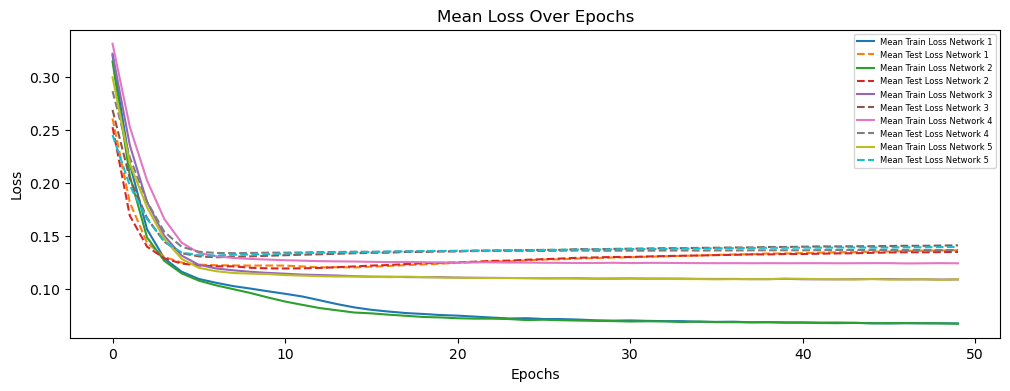

In [10]:
# Plot the training and validation losses for each one individually
plt.figure(figsize=(12, 4))

for i, (train_loss, test_loss) in enumerate(zip(mean_losses_tr, mean_losses_ts)):
    plt.plot(train_loss, label=f'Mean Train Loss Network {i + 1}')
    plt.plot(test_loss, linestyle='--', label=f'Mean Test Loss Network {i + 1}')

plt.legend(fontsize = 6)
plt.title('Mean Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Fold 1:
Epoch 1/150
71/71 [==============================] - 10s 54ms/step - loss: 0.3467 - val_loss: 0.3093
Epoch 2/150
71/71 [==============================] - 3s 39ms/step - loss: 0.2782 - val_loss: 0.2498
Epoch 3/150
71/71 [==============================] - 3s 41ms/step - loss: 0.2225 - val_loss: 0.1997
Epoch 4/150
71/71 [==============================] - 2s 35ms/step - loss: 0.1782 - val_loss: 0.1651
Epoch 5/150
71/71 [==============================] - 1s 13ms/step - loss: 0.1524 - val_loss: 0.1484
Epoch 6/150
71/71 [==============================] - 1s 9ms/step - loss: 0.1418 - val_loss: 0.1435
Epoch 7/150
71/71 [==============================] - 1s 17ms/step - loss: 0.1390 - val_loss: 0.1424
Epoch 8/150
71/71 [==============================] - 1s 19ms/step - loss: 0.1383 - val_loss: 0.1423
Epoch 9/150
71/71 [==============================] - 1s 11ms/step - loss: 0.1383 - val_loss: 0.1423
Epoch 10/150
71/71 [==============================] - 1s 10ms/step - loss: 0.1382 - val_loss

Text(0, 0.5, 'Loss')

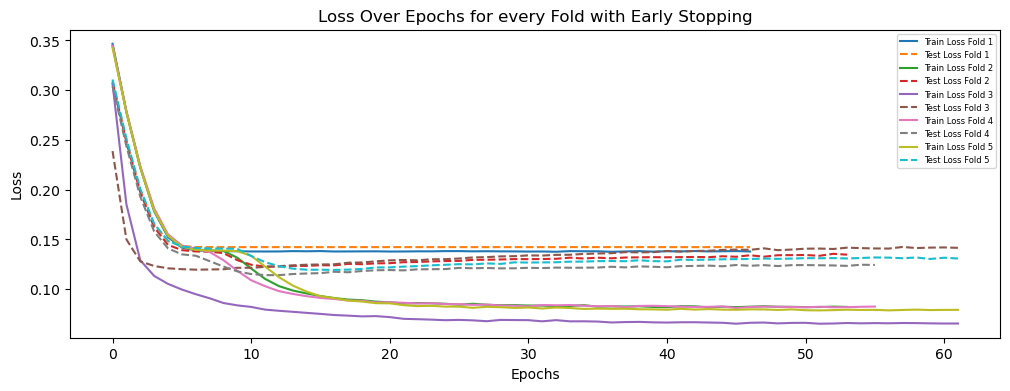

In [17]:
# Run the best model of the above using the early stopping criterion and plot the loss per fold for all the epochs.

train_loss, test_loss = ul.train_model(3000, 2, 0.001, 0.9, fold_dataset, 32, 150, True, False, 0.0, 0.0)

plt.figure(figsize=(12, 4))

for i, (tr_loss, ts_loss) in enumerate(zip(train_loss, test_loss)):
    plt.plot(tr_loss, label=f'Train Loss Fold {i + 1}')
    plt.plot(ts_loss, linestyle='--', label=f'Test Loss Fold {i + 1}')

plt.legend(fontsize = 6)
plt.title('Loss Over Epochs for every Fold with Early Stopping')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Fold 1:
Epoch 1/150
71/71 [==============================] - 4s 38ms/step - loss: 0.3222 - val_loss: 0.2606
Epoch 2/150
71/71 [==============================] - 2s 23ms/step - loss: 0.2071 - val_loss: 0.1674
Epoch 3/150
71/71 [==============================] - 1s 19ms/step - loss: 0.1384 - val_loss: 0.1334
Epoch 4/150
71/71 [==============================] - 1s 8ms/step - loss: 0.1167 - val_loss: 0.1266
Epoch 5/150
71/71 [==============================] - 1s 8ms/step - loss: 0.1084 - val_loss: 0.1238
Epoch 6/150
71/71 [==============================] - 1s 8ms/step - loss: 0.1021 - val_loss: 0.1215
Epoch 7/150
71/71 [==============================] - 1s 8ms/step - loss: 0.0979 - val_loss: 0.1209
Epoch 8/150
71/71 [==============================] - 1s 7ms/step - loss: 0.0936 - val_loss: 0.1201
Epoch 9/150
71/71 [==============================] - 1s 8ms/step - loss: 0.0903 - val_loss: 0.1203
Epoch 10/150
71/71 [==============================] - 1s 8ms/step - loss: 0.0874 - val_loss: 0.120

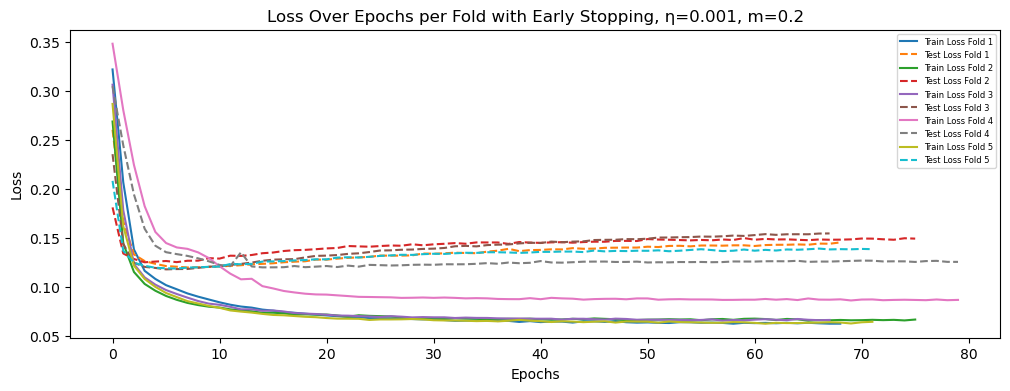

Fold 1:
Epoch 1/150
71/71 [==============================] - 6s 50ms/step - loss: 0.3127 - val_loss: 0.2494
Epoch 2/150
71/71 [==============================] - 2s 27ms/step - loss: 0.1949 - val_loss: 0.1602
Epoch 3/150
71/71 [==============================] - 4s 53ms/step - loss: 0.1335 - val_loss: 0.1317
Epoch 4/150
71/71 [==============================] - 3s 47ms/step - loss: 0.1156 - val_loss: 0.1254
Epoch 5/150
71/71 [==============================] - 3s 48ms/step - loss: 0.1074 - val_loss: 0.1227
Epoch 6/150
71/71 [==============================] - 4s 49ms/step - loss: 0.1016 - val_loss: 0.1210
Epoch 7/150
71/71 [==============================] - 5s 66ms/step - loss: 0.0969 - val_loss: 0.1202
Epoch 8/150
71/71 [==============================] - 4s 58ms/step - loss: 0.0933 - val_loss: 0.1200
Epoch 9/150
71/71 [==============================] - 4s 54ms/step - loss: 0.0904 - val_loss: 0.1198
Epoch 10/150
71/71 [==============================] - 2s 34ms/step - loss: 0.0875 - val_loss

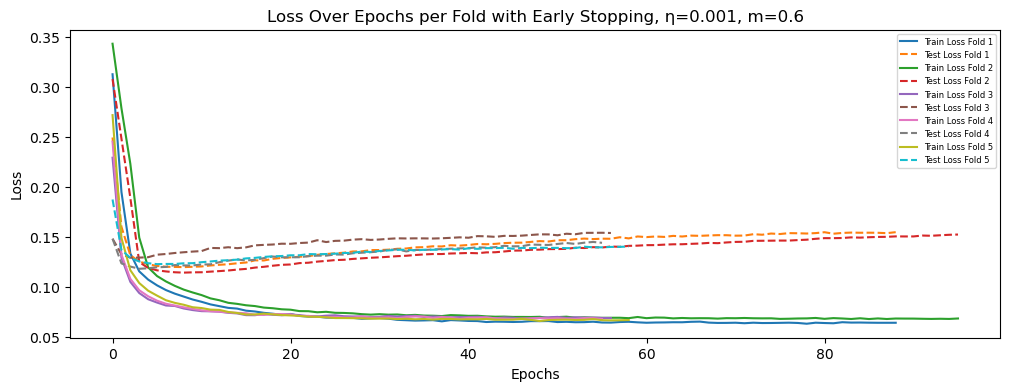

Fold 1:
Epoch 1/150
71/71 [==============================] - 2s 11ms/step - loss: 0.1477 - val_loss: 0.1424
Epoch 2/150
71/71 [==============================] - 0s 5ms/step - loss: 0.1322 - val_loss: 0.1753
Epoch 3/150
71/71 [==============================] - 1s 12ms/step - loss: 0.1203 - val_loss: 0.1362
Epoch 4/150
71/71 [==============================] - 0s 5ms/step - loss: 0.1095 - val_loss: 0.1350
Epoch 5/150
71/71 [==============================] - 0s 5ms/step - loss: 0.1029 - val_loss: 0.2175
Epoch 6/150
71/71 [==============================] - 0s 5ms/step - loss: 0.1024 - val_loss: 0.1977
Epoch 7/150
71/71 [==============================] - 0s 6ms/step - loss: 0.1053 - val_loss: 0.1840
Epoch 8/150
71/71 [==============================] - 1s 7ms/step - loss: 0.0983 - val_loss: 0.1752
Epoch 9/150
71/71 [==============================] - 1s 14ms/step - loss: 0.0986 - val_loss: 0.1826
Epoch 10/150
71/71 [==============================] - 0s 6ms/step - loss: 0.0970 - val_loss: 0.193

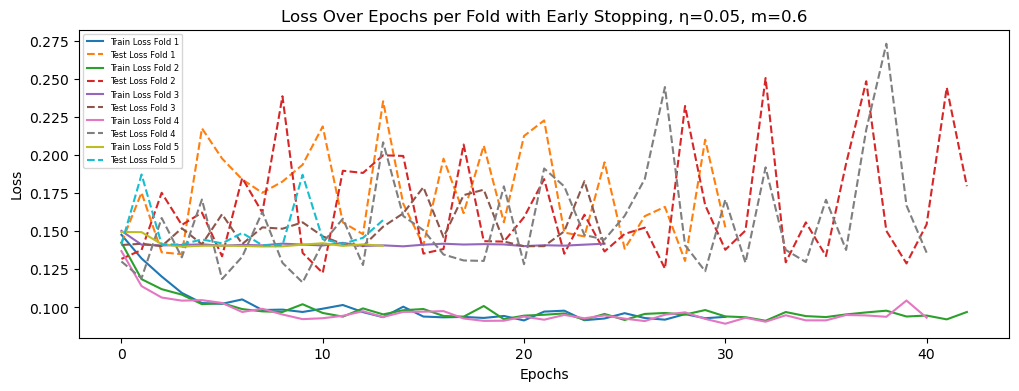

Fold 1:
Epoch 1/150
71/71 [==============================] - 3s 21ms/step - loss: 0.1476 - val_loss: 0.1589
Epoch 2/150
71/71 [==============================] - 0s 7ms/step - loss: 0.1413 - val_loss: 0.2183
Epoch 3/150
71/71 [==============================] - 1s 8ms/step - loss: 0.1447 - val_loss: 0.1950
Epoch 4/150
71/71 [==============================] - 0s 5ms/step - loss: 0.1431 - val_loss: 0.1672
Epoch 5/150
71/71 [==============================] - 0s 7ms/step - loss: 0.1427 - val_loss: 0.1635
Epoch 6/150
71/71 [==============================] - 1s 13ms/step - loss: 0.1413 - val_loss: 0.1626
Epoch 7/150
71/71 [==============================] - 0s 6ms/step - loss: 0.1420 - val_loss: 0.1880
Epoch 8/150
71/71 [==============================] - 0s 6ms/step - loss: 0.1436 - val_loss: 0.1705
Epoch 9/150
71/71 [==============================] - 0s 6ms/step - loss: 0.1407 - val_loss: 0.1596
Epoch 10/150
71/71 [==============================] - 0s 6ms/step - loss: 0.1420 - val_loss: 0.2313

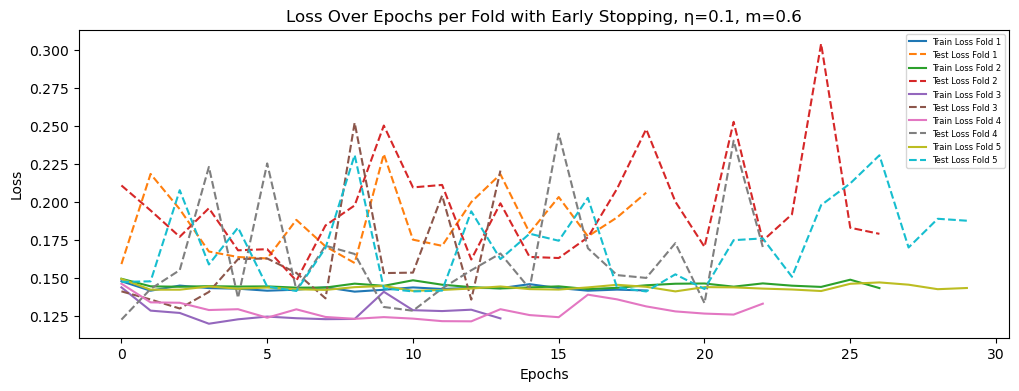

Final Means of Training Losses for each Learning Rate and Momentum combination:
η=0.001, m=0.2: 0.0812974749910245
η=0.001, m=0.6: 0.07738539748316958
η=0.05, m=0.6: 0.11578189170316615
η=0.1, m=0.6: 0.13735527425867472


In [18]:
# Test the effects of combinations of various learning rate and momentum values
learn_and_momentum_rates = [
    [0.001, 0.2],
    [0.001, 0.6],
    [0.05, 0.6],
    [0.1, 0.6]
]
final_means = []

for learning_rate, momentum in learn_and_momentum_rates:
    
    train_loss, test_loss = ul.train_model(3000, 2, learning_rate, momentum, fold_dataset, 32, 150, True, False, 0.0, 0.0)
    final_means.append(ul.mean_of_all(train_loss))
    
    
    plt.figure(figsize=(12, 4))
    for i, (tr_loss, ts_loss) in enumerate(zip(train_loss, test_loss)):
        plt.plot(tr_loss, label=f'Train Loss Fold {i + 1}')
        plt.plot(ts_loss, linestyle='--', label=f'Test Loss Fold {i + 1}')
    
    plt.legend(fontsize=6)
    plt.title(f'Loss Over Epochs per Fold with Early Stopping, η={lr}, m={momentum}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.show()

# After all models are trained and plotted, print the final means
print("Final Means of Training Losses for each Learning Rate and Momentum combination:")
for i, (lr, momentum) in enumerate(learn_and_momentum_rates):
    print(f"η={lr}, m={momentum}: {final_means[i]}")

Fold 1:
Epoch 1/150
71/71 [==============================] - 5s 45ms/step - loss: 0.3132 - val_loss: 0.2590
Epoch 2/150
71/71 [==============================] - 3s 44ms/step - loss: 0.2331 - val_loss: 0.1787
Epoch 3/150
71/71 [==============================] - 3s 37ms/step - loss: 0.1944 - val_loss: 0.1546
Epoch 4/150
71/71 [==============================] - 2s 29ms/step - loss: 0.1740 - val_loss: 0.1464
Epoch 5/150
71/71 [==============================] - 2s 35ms/step - loss: 0.1570 - val_loss: 0.1425
Epoch 6/150
71/71 [==============================] - 3s 35ms/step - loss: 0.1509 - val_loss: 0.1400
Epoch 7/150
71/71 [==============================] - 2s 35ms/step - loss: 0.1432 - val_loss: 0.1377
Epoch 8/150
71/71 [==============================] - 2s 34ms/step - loss: 0.1395 - val_loss: 0.1371
Epoch 9/150
71/71 [==============================] - 2s 31ms/step - loss: 0.1376 - val_loss: 0.1363
Epoch 10/150
71/71 [==============================] - 2s 35ms/step - loss: 0.1359 - val_loss

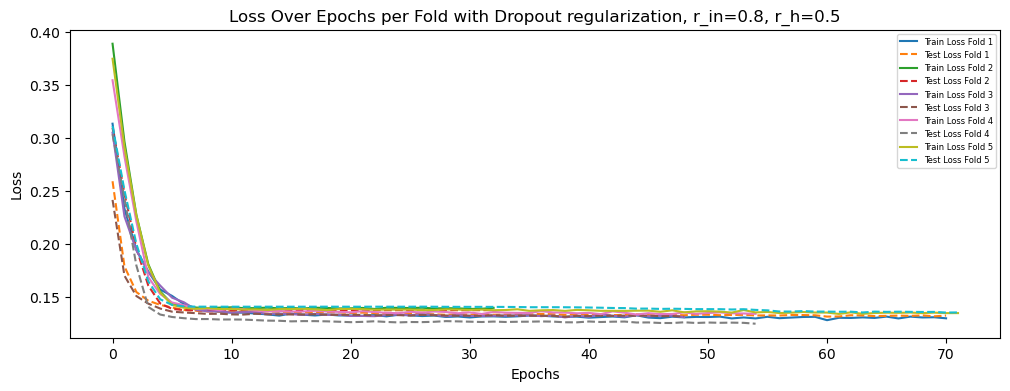

Fold 1:
Epoch 1/150
71/71 [==============================] - 2s 17ms/step - loss: 0.3080 - val_loss: 0.2304
Epoch 2/150
71/71 [==============================] - 1s 13ms/step - loss: 0.2366 - val_loss: 0.1768
Epoch 3/150
71/71 [==============================] - 1s 9ms/step - loss: 0.2055 - val_loss: 0.1629
Epoch 4/150
71/71 [==============================] - 1s 9ms/step - loss: 0.1772 - val_loss: 0.1464
Epoch 5/150
71/71 [==============================] - 1s 9ms/step - loss: 0.1534 - val_loss: 0.1393
Epoch 6/150
71/71 [==============================] - 1s 9ms/step - loss: 0.1417 - val_loss: 0.1340
Epoch 7/150
71/71 [==============================] - 1s 9ms/step - loss: 0.1365 - val_loss: 0.1345
Epoch 8/150
71/71 [==============================] - 1s 9ms/step - loss: 0.1324 - val_loss: 0.1338
Epoch 9/150
71/71 [==============================] - 1s 10ms/step - loss: 0.1315 - val_loss: 0.1334
Epoch 10/150
71/71 [==============================] - 1s 9ms/step - loss: 0.1317 - val_loss: 0.133

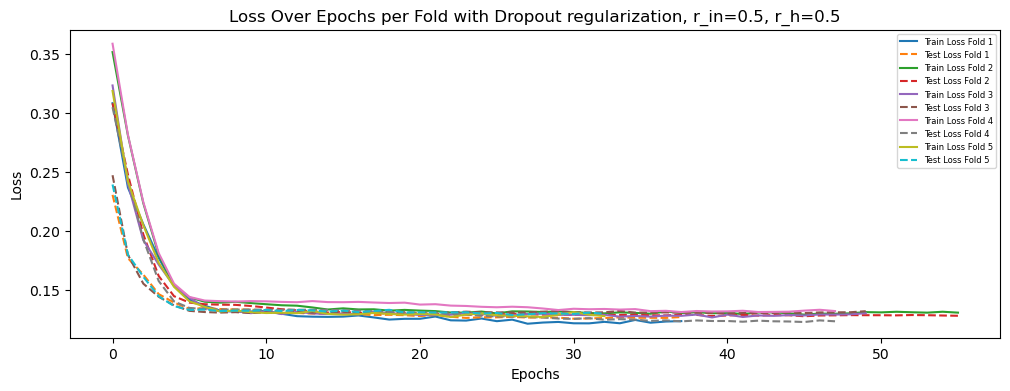

Fold 1:
Epoch 1/150
71/71 [==============================] - 2s 14ms/step - loss: 0.3296 - val_loss: 0.2675
Epoch 2/150
71/71 [==============================] - 1s 9ms/step - loss: 0.2303 - val_loss: 0.1749
Epoch 3/150
71/71 [==============================] - 1s 9ms/step - loss: 0.1735 - val_loss: 0.1421
Epoch 4/150
71/71 [==============================] - 1s 9ms/step - loss: 0.1625 - val_loss: 0.1364
Epoch 5/150
71/71 [==============================] - 1s 9ms/step - loss: 0.1513 - val_loss: 0.1334
Epoch 6/150
71/71 [==============================] - 1s 10ms/step - loss: 0.1462 - val_loss: 0.1317
Epoch 7/150
71/71 [==============================] - 1s 10ms/step - loss: 0.1416 - val_loss: 0.1314
Epoch 8/150
71/71 [==============================] - 1s 9ms/step - loss: 0.1360 - val_loss: 0.1308
Epoch 9/150
71/71 [==============================] - 1s 9ms/step - loss: 0.1347 - val_loss: 0.1305
Epoch 10/150
71/71 [==============================] - 1s 9ms/step - loss: 0.1344 - val_loss: 0.130

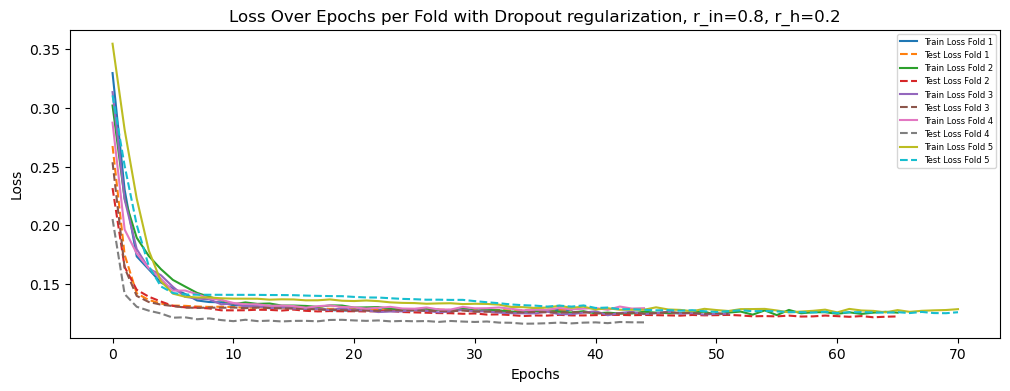

Final Means of Training Losses for each Dropout combination:
r_in=0.8, r_h=0.5: 0.14515350082609446
r_in=0.5, r_h=0.5: 0.1417403370070974
r_in=0.8, r_h=0.2: 0.1376558901795332


In [21]:
# Test the network using dropout regularization with various values for dropout rates for the input and hidden layers 
final_means = []

dropout_parameters = [
    [0.8, 0.5],
    [0.5, 0.5],
    [0.8, 0.2],
]

for dropout_in, dropout_h in dropout_parameters:
    
    train_loss, test_loss = ul.train_model(3000, 2, 0.001, 0.9, fold_dataset, 32, 150, have_callback=True, dropout=True, dropout_in=dropout_in, dropout_h=dropout_h)
    
    final_means.append(ul.mean_of_all(train_loss))
    
    plt.figure(figsize=(12, 4))
    for i, (tr_loss, ts_loss) in enumerate(zip(train_loss, test_loss)):
        plt.plot(tr_loss, label=f'Train Loss Fold {i + 1}')
        plt.plot(ts_loss, linestyle='--', label=f'Test Loss Fold {i + 1}')
    plt.legend(fontsize=6)
    plt.title(f'Loss Over Epochs per Fold with Dropout regularization, r_in={dropout_in}, r_h={dropout_h}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

print("Final Means of Training Losses for each Dropout combination:")
for i, (dropout_in, dropout_h) in enumerate(dropout_parameters):
    print(f"r_in={dropout_in}, r_h={dropout_h}: {final_means[i]}")